In [1]:
import os
from cadtoolkit.pc2g import CoronaryGraph, _read_centerlines_txt


In [2]:
from cadtoolkit.cfg import Config; Config.pc2g

{'xyz': [1, 2, 3],
 'id': 0,
 'sep': ' ',
 'presmooth_iterations': 100,
 'presmooth_passband': 0.1,
 'group': True,
 'merge': True,
 'convert_cell_data': True,
 'postsmooth_iterations': 100,
 'postsmooth_passband': 0.1}

In [110]:
path = "../cartesian_data/" # change this path

files = os.listdir(path)
if not os.path.exists('graphs'):
    os.makedirs('graphs')

In [ ]:
# print(files)
# print(files[0])
# f= files[0]

In [111]:
for f in files: # uncomment this when sure its working...

    g = CoronaryGraph() # creates empty graph 'g'
    updated_g = g.from_txt(os.path.join(path, f))

    # Save the CoronaryGraph() object
    f_without_ext = os.path.splitext(f)[0] # remove .txt extension
    updated_g.sg=None
    updated_g.save(f"graphs/{f_without_ext}")

converting points
converting point data
converting cell data
Writing VTK XML surface file.


/home/561/qp2123/miniconda3/envs/treelstm/lib/python3.7/site-packages/vmtk/vmtknumpytocenterlines.py:61: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if np.issubdtype(self.ArrayDict['PointData'][pointKey].dtype, float):
/home/561/qp2123/miniconda3/envs/treelstm/lib/python3.7/site-packages/vmtk/vmtknumpytocenterlines.py:65: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(self.ArrayDict['PointData'][pointKey].dtype, checkDt):


converting points
converting point data
converting cell data
Writing VTK XML surface file.
converting points
converting point data
converting cell data
Writing VTK XML surface file.
converting points
converting point data
converting cell data
Writing VTK XML surface file.
converting points
converting point data
converting cell data
Writing VTK XML surface file.


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/home/561/qp2123/miniconda3/envs/treelstm/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3417, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-111-aae3f6edc256>", line 4, in <module>
    updated_g = g.from_txt(os.path.join(path, f))
  File "/home/561/qp2123/CADToolkit/cadtoolkit/pc2g.py", line 30, in from_txt
    centerline = _read_centerlines_txt(path, merge=True)
  File "/home/561/qp2123/CADToolkit/cadtoolkit/cfg.py", line 27, in inner
    return func(*args, **kwargs)
  File "/home/561/qp2123/CADToolkit/cadtoolkit/pc2g.py", line 237, in _read_centerlines_txt
    centerline = ctr_group(centerline, 'Radius')
  File "/home/561/qp2123/CADToolkit/cadtoolkit/setup.py", line 137, in ctr_group
    op.Update()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/561/qp2123/miniconda3/envs/treelstm/lib/pytho

TypeError: object of type 'NoneType' has no len()

In [ ]:
print(f"Start: {updated_g.startpts()}")
print(f"Bifs: {updated_g.bifurcations()}")
# print(f"Inner: {points.inner_points()}")
print(f"End: {updated_g.endpoints()}")


In [ ]:
# for idx, val in updated_g.nodes.items():
#     print(idx, val)

In [ ]:
# Showing info for random points
print(updated_g.nodes[0])
print(updated_g.nodes[10])

In [ ]:
# Plot graph 

# import networkx as nx
# from networkx.drawing.nx_agraph import graphviz_layout
# import matplotlib.pyplot as plt

# skeleton_graph = updated_g.collapse_intermediates()
# plt.title('Coronary Map')
# pos=graphviz_layout(skeleton_graph, prog='dot')
# nx.draw(skeleton_graph, pos, with_labels=True, arrows=True) # good
# plt.savefig('nx_test.png')

In [3]:
# Attempt to create Graph dataset
import torch
from torch_geometric.data import Data, DataLoader

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())

1.6.0
10.2
True


In [114]:
from torch_geometric.utils import from_networkx
from torch_geometric.data import InMemoryDataset # base class

class GraphDataset(InMemoryDataset): # subclass from base class
    
    num_classes = 10
    num_node_features = 3
    
    def __init__(self, root, transform=None, pre_transform=None):
        # calling super class
        super(GraphDataset,self).__init__(root, transform, pre_transform) 
        self.data, self.slices = torch.load(self.processed_paths[0])

    @property
    def raw_file_names(self):
        return [f"{self.root}"] # like calling super variables in Java

    @property
    def processed_file_names(self):
        return ['processed']

    def download(self):
        # Download to `self.raw_dir`.
        pass
    
    def process(self):
        # Read data into huge `Data` list.

        data_list = []

        files = os.listdir("graphs")
        for f in files:

            if f == ".ipynb_checkpoints": continue

            a = CoronaryGraph() # another empty graph
            loadedGraph = a.load(f"graphs/{f}")
            skeleton_graph = loadedGraph.collapse_intermediates()
            data = from_networkx(skeleton_graph)
            data.y = data.ids
            data_list.append(data)

#             print(f"{f} \n {data}")

        if self.pre_filter is not None:
            data_list = [data for data in data_list if self.pre_filter(data)]

        if self.pre_transform is not None:
            data_list = [self.pre_transform(data) for data in data_list]

        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

all_data = GraphDataset(root="all")


Processing...
Done!


In [115]:
# Split train and test data
import numpy as np

all_data = all_data.shuffle()

train_ratio = 0.8
threshold = int(train_ratio*len(all_data))

train_data, val_data = all_data[:threshold], all_data[threshold:]

print(len(train_data), len(val_data))

8 2


In [116]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [117]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import torch.nn as nn

class GraphCNN(nn.Module):
    def __init__(self):
        super(GraphCNN, self).__init__()
        self.conv1 = GCNConv(train_data.num_node_features, 16)
        self.conv2 = GCNConv(16, train_data.num_classes)

    def forward(self, data):
        x, edge_index = data.loc, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        
        x = self.conv2(x, edge_index)
        return x


class TreeLabNet(torch.nn.Module):
    def __init__(self, hidden_dim, emb_dim=100, num_linear=1):
        super().__init__()
        
        self.cnn=GraphCNN()
        
        # hidden and cell states for LSTM
#         self.h = torch.randn(1, 1, hidden_dim).to(device) 
#         self.c = torch.randn(1, 1, hidden_dim).to(device)
        self.lstm=nn.LSTM(
            input_size=emb_dim, 
            hidden_size=hidden_dim, 
            num_layers=1)    
        
        # fc layers
        self.fc1 = nn.Linear(128, 64) #flattening.
        self.fc2 = nn.Linear(64, train_data.num_classes) # 64 in, 9 out bc we're doing 9 classes 

    def forward(self, x): # used to be data
        
        x = self.cnn(x)
        
        x = x.view(-1, 1, x.shape[1])
#         print(x.shape)
        lstm_out, (h,c) = self.lstm(x)
#         print(lstm_out[0:3])
#         dim = .shape[1]*x.shape[2]
#         lstm_out = lstm_out.view(-1, dim) 
# #         print(x.shape)
        lstm_out = self.fc1(lstm_out)
        lstm_out = F.relu(lstm_out)
        
        lstm_out = self.fc2(lstm_out)
        
        dim = lstm_out.shape[1]*lstm_out.shape[2]
        lstm_out = lstm_out.view(-1, dim) 

        return F.log_softmax(lstm_out, dim=1)

In [122]:
torch.autograd.set_detect_anomaly(True) # checks code location that breaks 
em_sz = 10
nh = 128 # no of hidden units for lstm
nl = 3
model = TreeLabNet(nh, emb_dim=em_sz).to(device)
trainloader = DataLoader(train_data, batch_size=2) # adjust batch size
valloader = DataLoader(val_data, batch_size=2) # adjust batch size

optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4) 

In [123]:
def train():
    model.train()
    
    sumCorrect = 0
    sumTotal = 0 
    running_loss = 0
    for data in trainloader:

        optimizer.zero_grad()

        data = data.to(device)
        out = model(data)

        _, predicted = torch.max(out.data, 1)

        # Loss
        loss = F.nll_loss(out, data.ids.long())
        running_loss += loss.item()

        # Accuracy
        sumCorrect += (predicted == data.ids).sum().item()
        sumTotal += data.ids.size(0)

        loss.backward(retain_graph=True)
        optimizer.step()

    total_loss_per_epoch = round(running_loss/len(train_data), 3)
    acc = round(sumCorrect/sumTotal, 3)

    return acc, total_loss_per_epoch
#         print(f"Epoch {epoch+1} ----- Accuracy: {acc} Loss: {total_loss_per_epoch}")

In [124]:
def evaluate():
    model.eval()
    
    sumCorrect = 0
    sumTotal = 0 
    running_loss = 0
    with torch.no_grad():
        for data in valloader:
            data = data.to(device)
            out = model(data)
    #         print(out.data.shape)

            _, predicted = torch.max(out.data, 1)

            # Loss
            loss = F.nll_loss(out, data.ids.long())
            running_loss += loss.item()

            loss = F.nll_loss(out, data.ids.long())
            running_loss += loss.item()

            # Accuracy
            sumCorrect += (predicted == data.ids).sum().item()
            sumTotal += data.ids.size(0)

#             loss.backward(retain_graph=True)
    total_loss_per_epoch = round(running_loss/len(train_data), 3)
    acc = round(sumCorrect/sumTotal, 3)
    return acc, total_loss_per_epoch
    

In [133]:
EPOCHS = 10
train_acc_list, train_loss_list, val_acc_list, val_loss_list = [],[],[],[]
for epoch in range(EPOCHS):

    sumCorrect = 0
    sumTotal = 0 
    running_loss = 0
    train_acc, train_loss = train()
    val_acc, val_loss = evaluate()
    train_acc_list.append(train_acc)
    train_loss_list.append(train_loss) 
    val_acc_list.append(val_acc) 
    val_loss_list.append(val_loss) 
    
    print(f"Epoch {epoch+1} --- Train Acc: {train_acc} Train Loss: {train_loss} Val Acc: {val_acc} Val Loss: {val_loss}")

Epoch 1 --- Train Acc: 0.99 Train Loss: 0.048 Val Acc: 0.562 Val Loss: 0.578
Epoch 2 --- Train Acc: 0.98 Train Loss: 0.036 Val Acc: 0.562 Val Loss: 0.601
Epoch 3 --- Train Acc: 0.959 Train Loss: 0.06 Val Acc: 0.594 Val Loss: 0.671
Epoch 4 --- Train Acc: 0.98 Train Loss: 0.038 Val Acc: 0.562 Val Loss: 0.762
Epoch 5 --- Train Acc: 0.959 Train Loss: 0.079 Val Acc: 0.531 Val Loss: 0.876
Epoch 6 --- Train Acc: 1.0 Train Loss: 0.031 Val Acc: 0.531 Val Loss: 0.939
Epoch 7 --- Train Acc: 0.939 Train Loss: 0.069 Val Acc: 0.562 Val Loss: 0.989
Epoch 8 --- Train Acc: 0.949 Train Loss: 0.057 Val Acc: 0.562 Val Loss: 0.994
Epoch 9 --- Train Acc: 0.99 Train Loss: 0.034 Val Acc: 0.531 Val Loss: 1.002
Epoch 10 --- Train Acc: 0.959 Train Loss: 0.056 Val Acc: 0.531 Val Loss: 0.996


In [134]:
import matplotlib.pyplot as plt
from matplotlib import style
import pandas as pd

style.use("ggplot")

def create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list):
    epoch = list(range(0, EPOCHS, 1))

    d = {'epochs': epoch,
        'train_acc': train_acc_list,
        'train_loss': train_loss_list,
        'val_acc': val_acc_list, 
        'val_loss': val_loss_list}

    df = pd.DataFrame(d)

    df['train_acc_avg'] = df['train_acc'].ewm(alpha=.02).mean()  # exponential weighted moving average
    df['val_acc_avg'] = df['val_acc'].ewm(alpha=.02).mean()
    df['train_loss_avg'] = df['train_loss'].ewm(alpha=.02).mean()
    df['val_loss_avg'] = df['val_loss'].ewm(alpha=.02).mean()

    # Then plot using pandas:
    df.plot(x='epochs', y=['train_acc_avg', 'val_acc_avg'], figsize=(8,4))
    plt.ylabel("Accuracy")
    df.plot(x='epochs', y=['train_loss_avg', 'val_loss_avg'], figsize=(8,4))
    plt.ylabel("Loss")

    plt.show()

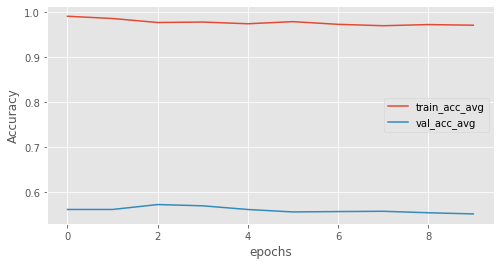

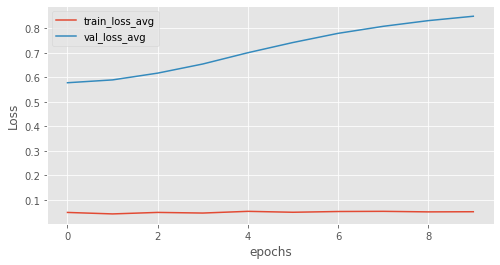

In [135]:
create_acc_loss_graph(train_acc_list, train_loss_list, val_acc_list, val_loss_list)